### Imports and loads

In [1]:
import sys, yaml, re, os
from copy import deepcopy
sys.path.append('../lib')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from iminuit import Minuit
from prettytable import PrettyTable
from stat_utils import correlation_from_covariance
from scipy.interpolate import interp1d

In [2]:
from spdc_model_utils import countProbaIdler, countProbaSignal
from spdc_model_utils import countProbaS1S2, countProbaiS, countProbai12
from spdc_model_utils import g2_0

In [3]:
lambda_s0 = pd.read_csv('../data/schmidt_eigenvalues.csv', index_col=0)
df = pd.read_csv('../data/measured_rates_etaAndMu.csv')
with open('../data/efficiencies_estimation.yml', 'r') as fileIn:
    eta0 = yaml.load(fileIn, Loader=yaml.Loader)
for k in eta0.keys():
    eta0[k[-1]] = eta0.pop(k)

### Definitions

In [4]:
class FitResults:
    def __init__(self, mu=df['mu0'], mu_err=df['mu0_err'], eta=eta0, 
                 rate=1e6, rate_err=1.3,
                 k=2.71, k_err=0.2, 
                 sigma_xy=0, sigma_xy_err=0,
                 sigma_p=0, sigma_p_err=0
                ):
        self.mu = mu
        self.mu_err = mu_err
        self.rate = rate
        self.rate_err = rate_err
        self.eta = eta
        self.k = k
        self.k_err = k_err
        self.sigma_xy = sigma_xy
        self.sigma_xy_err = sigma_xy_err
        self.sigma_p = sigma_p
        self.sigma_p_err = sigma_p_err

In [5]:
def getLambda(**kwargs):
    out = np.zeros_like(lambda_s0['central'])
    out += lambda_s0['central'].to_numpy()
    for k, v in kwargs.items():
        if not k+'_Up' in lambda_s0.columns:
            print('[ERROR]', k, 'not recognized')
            print('Choose among:', ', '.join([n[:-3] for n in lambda_s0.columns if n.endswith('_Up')]))
            raise
        
        auxName = k+'_Up' if v >=0 else k+'_Dw'
        
        ww = np.abs(v)
        # Saturation
#         if ww > 1.8:
#             ww = 1.8 + 0.2*(ww-1.8)
        out += ww*(lambda_s0[auxName] - lambda_s0['central']).to_numpy()
    return np.where(out < 0, 0, out)

In [6]:
schmidt_eigenvalues_var_dic = {
    'Gamma': [r'$\Gamma$', r'400 mm$^{-1}$'],
    'sigma_d': [r'$\sigma_d$', '5 nm'],
    'sigma_p': [r'$\sigma_p$', '10 GHz'],
    'sigma_xy': [r'$\sigma_{xy}^{cwdm}$', '1 nm'],
#     'w_central': [r'$\omega_{c}$', '1 nm']
}

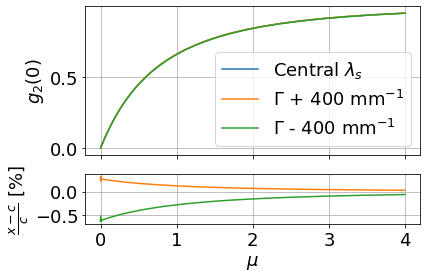

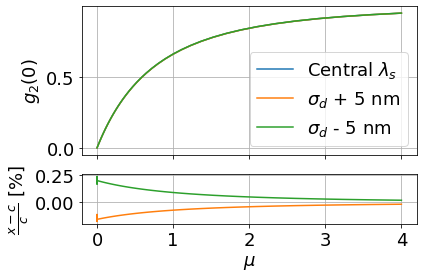

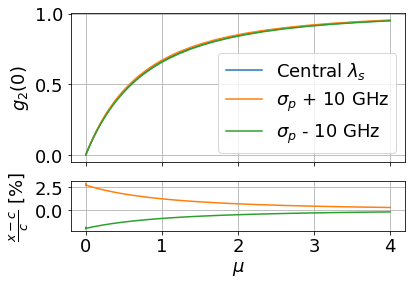

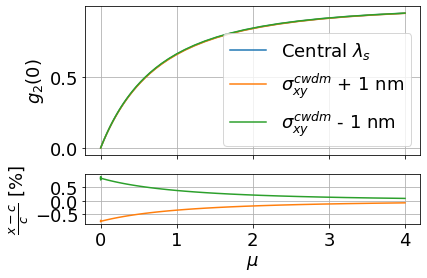

In [7]:
printDir = '../fig/schmidt_eigenvalues_var'
if not os.path.isdir(printDir):
    os.makedirs(printDir)

for v, s in schmidt_eigenvalues_var_dic.items():
    test_mu = np.logspace(-4, np.log10(4), 100)
    fig1, (axu, axd) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    yc = g2_0(test_mu, 0.3, 0.4, 0.35, 3., getLambda())
    axu.plot(test_mu, yc, label='Central $\lambda_s$')
    yu = g2_0(test_mu, 0.3, 0.4, 0.35, 3., getLambda(**{v:1}))
    axu.plot(test_mu, yu, label=' + '.join(s))
    yd = g2_0(test_mu, 0.3, 0.4, 0.35, 3., getLambda(**{v:-1}))
    axu.plot(test_mu, yd, label=' - '.join(s))
    axu.legend(loc='best')
    axd.plot(test_mu, 100*(yu - yc)/yc, color='C1')
    axd.plot(test_mu, 100*(yd - yc)/yc, color='C2')
    axd.set_xlabel(r'$\mu$')
    axu.set_ylabel(r'$g_2(0)$')
    axd.set_ylabel(r'$\frac{x - c}{c}$ [%]')
    axd.grid()
    axu.grid()
    fig1.savefig(printDir+'/prefit_'+v+'.png' , bbox_inches='tight')

In [8]:
def plotSingleDetectors(data=df, fr=None, saveas=None):
    lambdas = getLambda(sigma_xy=fr.sigma_xy, sigma_p=fr.sigma_p)
    plt.rcParams.update({'font.size': 18})
    fig1, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    axs[0,0].set_title('Idler detector')
    axu = axs[0,0]
    axd = axs[1,0]
    
    detectors = {'Ci_tot': 'Threshold', 'Ci_single': 'PNR'}
    kappa = {'Ci_tot': 0, 'Ci_single': fr.k}
    for i, (n, tag) in enumerate(detectors.items()):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        yModel = countProbaIdler(fr.mu, fr.eta['i'][0], kappa[n], lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaIdler(fr.mu+dx, fr.eta['i'][0], kappa[n], lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    axs[0,1].set_title('Signal detectors')
    axu = axs[0,1]
    axd = axs[1,1]
    
    detectors = [['C1_tot', 'Signal 1'], ['C2_tot', 'Signal 2']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i+2), label=tag)
        yModel = countProbaSignal(fr.mu, fr.eta[str(i+1)][0], lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i+2), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaSignal(fr.mu+dx, fr.eta[str(i+1)][0], lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i+2))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()
    if saveas is not None:
        fig1.savefig(saveas, bbox_inches='tight')  

In [9]:
def plotTwofold(data=df, fr=None, saveas=None):
    lambdas = getLambda(sigma_xy=fr.sigma_xy, sigma_p=fr.sigma_p)
    plt.rcParams.update({'font.size': 18})
    fig1, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    axs[0,0].set_title('Threshold detectors')
    axu = axs[0,0]
    axd = axs[1,0]
    
    detectors = {'Ci1_thr': 'Idler & S1', 'Ci2_thr': 'Idler & S2', 'C12': 'S1 & S2'}
    for i, (n, tag) in enumerate(detectors.items()):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        
        def model(x):
            if n.startswith('Ci1'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['1'][0], k=0, lambdas=lambdas)
            elif n.startswith('Ci2'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['2'][0], k=0, lambdas=lambdas)
            elif n.startswith('C12'):
                return countProbaS1S2(x, fr.eta['1'][0], fr.eta['2'][0], lambdas=lambdas)
                    
        yModel = model(fr.mu)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - model(fr.mu+dx)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    
    
    axs[0,1].set_title('PNR detector')
    axu = axs[0,1]
    axd = axs[1,1]
    
    detectors = [['Ci1_pnr', 'Idler & S1'], ['Ci2_pnr', 'Idler & S2']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i+2), label=tag)
        yModel = countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i+2), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i+2))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()
    if saveas is not None:
        fig1.savefig(saveas, bbox_inches='tight')

In [10]:
def plot_g2_0(data=df, fr=None, figsize=(8,6), drawIdealModels=False, saveas=None, showLegend=True):
    lambdas = getLambda(sigma_xy=fr.sigma_xy, sigma_p=fr.sigma_p)
    plt.rcParams.update({'font.size': 18})
    fig1, (axu, axd) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    detectors = [['g2_pnr', 'PNR'], ['g2_thr', 'Threshold']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]
        yerr = data[n+'_err']
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        
        K = fr.k if i == 0 else 0
        yModel = g2_0(fr.mu, fr.eta['i'][0], fr.eta['1'][0], fr.eta['2'][0], K, lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - g2_0(fr.mu+dx, fr.eta['i'][0], fr.eta['1'][0], fr.eta['2'][0], K, lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        print('Sum pull^2:', np.sum(np.square(pull)))
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    
    if drawIdealModels:
        test_mu = np.logspace(-4, max(np.log10(0.015), np.log10(np.max(fr.mu))), 100)
        y = g2_0(test_mu, 0.87, 0.87, 0.87, fr.k, lambdas)
        axu.plot(test_mu, y, color='C2', ls='-', label=r'PNR: $\eta=0.87$, k={:.2f}'.format(fr.k))
        y = g2_0(test_mu, 0.87, 0.87, 0.87, 10, lambdas)
        axu.plot(test_mu, y, color='C3', ls='-', label=r'PNR: $\eta=0.87$, k=10')
        
    axu.grid()
    axd.grid()
    axu.set_ylabel(r'$g_2(0)$')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    if showLegend:
        axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()
    if saveas is not None:
        fig1.savefig(saveas, bbox_inches='tight')      
        
    return fig1, (axu, axd)

In [25]:
def plot_g2_0_zoommed(data=df, fr=None, figsize=(9,3.5), drawIdealModels=True, saveas=None, showLegend=True, force_xticks=True):
    lambdas = getLambda(sigma_xy=fr.sigma_xy, sigma_p=fr.sigma_p)
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=figsize)
    test_mu = np.linspace(1e-5, max(0.029, np.max(fr.mu)), 300)
    g2_0_wp = 0.007
    
    detectors = [['g2_pnr', 'PNR'], ['g2_thr', 'Threshold']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]
        yerr = data[n+'_err']
        
        K = fr.k if i == 0 else 0
        x = np.linspace(np.min(fr.mu), 0.020)#np.max(fr.mu), 100)
        yModel = g2_0(x, fr.eta['i'][0], fr.eta['1'][0], fr.eta['2'][0], K, lambdas)
        plt.plot([0] + list(x), [0] + list(yModel), color='C'+str(i), ls='-')
        
        idxMin = np.argmin(np.abs(g2_0_wp - g2_0(test_mu, fr.eta['i'][0], fr.eta['1'][0], fr.eta['2'][0], K, lambdas)))
        mu_star = test_mu[idxMin]
        g2_star = g2_0(mu_star, fr.eta['i'][0], fr.eta['1'][0], fr.eta['2'][0], K, lambdas)
        plt.plot(2*[mu_star], [0, g2_star], ':', color='C'+str(i), lw=2)
        plt.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag+', $\mu_{\ g_2(0) = 0.007}$'+' = {:.4f}'.format(mu_star))
    
    if drawIdealModels:
        y = g2_0(test_mu, 0.87, 0.87, 0.87, fr.k, lambdas)
        idxMin = np.argmin(np.abs(g2_0_wp - y))
        mu_star = test_mu[idxMin]
        g2_star = y[idxMin]
        print('mu_star:', mu_star)
        plt.plot(2*[mu_star], [0, g2_star], ':', color='C2', lw=2)
        plt.plot(test_mu, y, color='C2', ls='-', label=r'PNR: $\eta=0.87$, k={:.2f}'.format(fr.k)+', $\mu_{\ g_2(0) = 0.007}$'+' = {:.4f}'.format(mu_star))
        
        y = g2_0(test_mu, 0.87, 0.87, 0.87, 10, lambdas)
        idxMin = np.argmin(np.abs(g2_0_wp - y))
        mu_star = test_mu[idxMin]
        g2_star = y[idxMin]
        print('mu_star (k=10):', mu_star)
        plt.plot(2*[mu_star], [0, g2_star], ':', color='C3', lw=2)
        plt.plot(test_mu, y, color='C3', ls='-', label=r'PNR: $\eta=0.87$, k=10'+', $\mu_{\ g_2(0) = 0.007}$'+' = {:.4f}'.format(mu_star))
        
    
    plt.plot([0, np.max(test_mu)], 2*[g2_0_wp], '--', color='gray', lw=2)
    plt.ylabel(r'$g_2(0)$')
    plt.xlabel(r'$\mu$')
    plt.ylim(0,0.022)
    if force_xticks:
#         plt.xticks(np.linspace(0, 0.020, 6))
        plt.yticks(np.linspace(0, 0.020, 6))
        pass
    if showLegend:
        plt.legend(loc='upper right', fontsize=12)
    
    plt.tight_layout()
    if saveas is not None:
        plt.savefig(saveas, bbox_inches='tight')

# Prefit plots

Sum pull^2: 90.05900425473547
Sum pull^2: 124.56579300259678


(<Figure size 576x432 with 2 Axes>,
 (<AxesSubplot:ylabel='$g_2(0)$'>,
  <AxesSubplot:xlabel='$\\mu$', ylabel='Pull [$\\sigma$]'>))

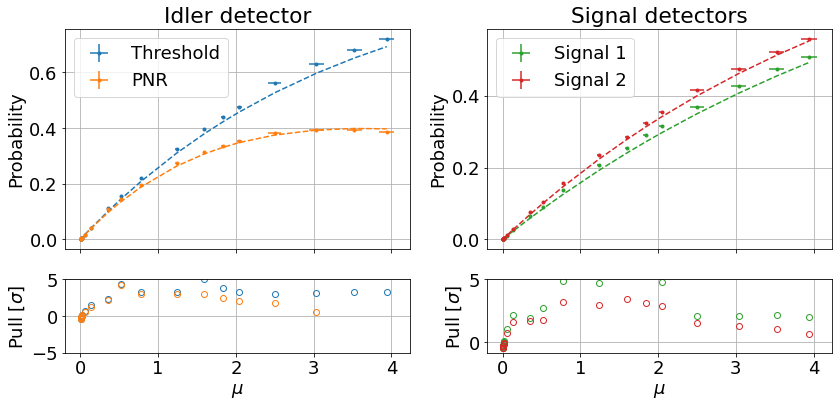

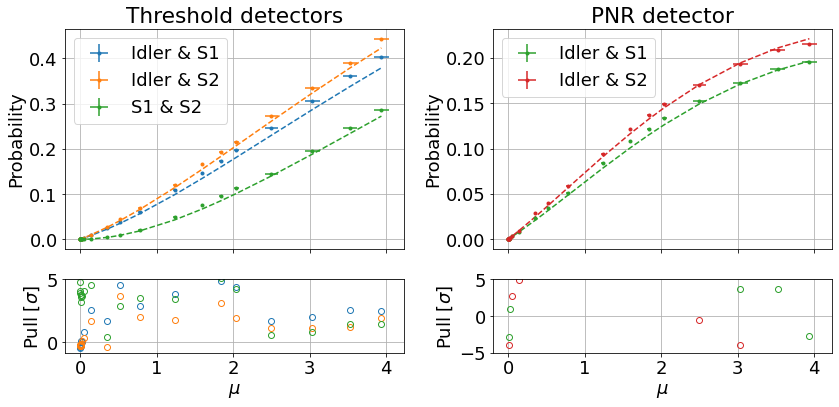

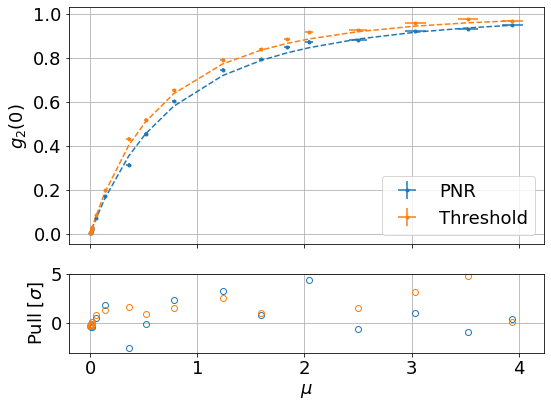

In [12]:
plotSingleDetectors(fr=FitResults())

plotTwofold(fr=FitResults())

plot_g2_0(fr=FitResults())

mu_star: 0.019013478260869566
mu_star (k=10): 0.02870913043478261


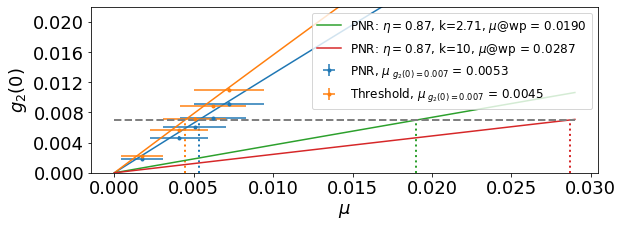

In [13]:
fr = FitResults()
fr.mu = fr.mu[:5]
fr.mu_err = fr.mu_err[:5]

data = df.iloc[:5]
plot_g2_0_zoommed(data, fr, drawIdealModels=True, showLegend=True)

# The fit

## Base fit

- Fit simultaneous of: $g_2(0)$ in THR and PNR mode.
- Mean photons ($\mu$) gaussian constrained to calibration values.
- Efficiencies ($\eta$) fully correlated among different currents and uncorrelated among detectors. Gaussian prior given by the calibration.
- Uncertainty on Schmidt eigenvalues ($\lambda_s$) given by $\sigma_{xy}^{cwdm} = 13 \pm 1$ nm
- $k$ free to float

In [14]:
inputData = df
eta_constrain = eta0

def cost_NLL(inputs):
    nPts = inputData.shape[0]
    mu = inputs[:nPts]
    eta_i, eta_1, eta_2 = inputs[nPts: nPts+3]
    sigma_xy = inputs[-3]
    sigma_p = inputs[-2]
    k = inputs[-1]
    
    ls = getLambda(sigma_xy=sigma_xy, sigma_p=sigma_p)
#     ls = getLambda(sigma_p=sigma_p)
#     ls = getLambda(sigma_xy=sigma_xy)
    
    NLL = 0
    
    # Signal counts
#     rate = 1e6
#     dy = inputData['C1_tot'] - rate*countProbaSignal(mu, eta_1, ls)
#     NLL += 0.5*np.sum(np.square(dy/inputData['C1_tot_err']))
    
#     dy = inputData['C2_tot'] - rate*countProbaSignal(mu, eta_2, ls)
#     NLL += 0.5*np.sum(np.square(dy/inputData['C2_tot_err']))
    
#     dy = inputData['C12'] - rate*countProbaS1S2(mu, eta_1, eta_2, ls)
#     NLL += 0.5*np.sum(np.square(dy/inputData['C12_err']))
    
    
    # Threshold detector
    dy = inputData['g2_thr'] - g2_0(mu, eta_i, eta_1, eta_2, 0, ls)
    NLL += 0.5*np.sum(np.square(dy/inputData['g2_thr_err']))
    
    # PNR detector
    dy = inputData['g2_pnr'] - g2_0(mu, eta_i, eta_1, eta_2, k, ls)
    NLL += 0.5*np.sum(np.square(dy/inputData['g2_pnr_err']))
    
    # Contraints
    NLL += 0.5*np.sum(np.square((mu - inputData['mu0'])/inputData['mu0_err']))
    NLL += 0.5*np.square((eta_i - eta_constrain['i'][0]) / eta_constrain['i'][1])
    NLL += 0.5*np.square((eta_1 - eta_constrain['1'][0]) / eta_constrain['1'][1])
    NLL += 0.5*np.square((eta_2 - eta_constrain['2'][0]) / eta_constrain['2'][1])
    NLL += 0.5*np.square(sigma_xy)
    NLL += 0.5*np.square(sigma_p)
    
    return NLL

cost_NLL.errordef = Minuit.LIKELIHOOD

In [15]:
parNames  = ['mu_'+str(i) for i in range(inputData.shape[0])]
p_0 = list(inputData['mu0'])
parNames += ['eta_i', 'eta_1', 'eta_2']
p_0 += [eta0['i'][0], eta0['1'][0], eta0['2'][0]]
parNames += ['sigma_xy', 'sigma_p', 'k']
p_0 += [0, 0, 2.5]
p_0 = np.array(p_0)

# Uncertanties as defined in NLL constraints
p_0_err = list(inputData['mu0_err'])
p_0_err += [eta0['i'][1], eta0['1'][1], eta0['2'][1]]
p_0_err += [1., 1., None]

print('Initial NLL: {:.1f}'.format(cost_NLL(p_0)))
minimizer = Minuit(cost_NLL, p_0, name=parNames)
minimizer.print_level = 1
minimizer.strategy = 0
minimizer.throw_nan = True
minimizer.migrad() # run optimiser
print('Valid:', minimizer.valid)
print('Accurate:', minimizer.accurate)
p_hat = np.array(minimizer.values)
print('Final NLL: {:.1f}'.format(cost_NLL(p_hat)))
minimizer.hesse()   # run covariance estimator
p_hat_err = np.array(minimizer.errors)

Initial NLL: 318.0
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0216 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 0.284647
W VariableMetricBuilder gdel = -1.74358
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 186.777 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0951149
W VariableMetricBuilder gdel = -138.803
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 61287.1 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 7110.39 is above tolerance 0.001
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.00628986 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -8.63749e-12
W MnPosDef non-positive diagon

/Users/olmo/cernbox/PhotonNumberResolving_SPDC/scripts/../lib/spdc_model_utils.py:114: RuntimeWarning: invalid value encountered in true_divide
  out /= countProbaiS(mu, eta_i, eta_1, k, lambdas) * countProbaiS(mu, eta_i, eta_2, k, lambdas)
/Users/olmo/cernbox/PhotonNumberResolving_SPDC/scripts/../lib/spdc_model_utils.py:113: RuntimeWarning: overflow encountered in multiply
  out = countProbai12(mu, eta_i, eta_1, eta_2, k, lambdas) * countProbaIdler(mu, eta_i, k, lambdas)
/Users/olmo/cernbox/PhotonNumberResolving_SPDC/scripts/../lib/spdc_model_utils.py:114: RuntimeWarning: overflow encountered in multiply
  out /= countProbaiS(mu, eta_i, eta_1, k, lambdas) * countProbaiS(mu, eta_i, eta_2, k, lambdas)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/olmo/cernbox/PhotonNumberResolving_SPDC/scripts/../lib/spdc_model_u

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 45752 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 38861.8 is above tolerance 0.001


/Users/olmo/cernbox/PhotonNumberResolving_SPDC/scripts/../lib/spdc_model_utils.py:104: RuntimeWarning: overflow encountered in multiply
  out = 2**k*(term1 - term2 - term3 + term4 - term5 + term6 + term7 - term8)
/Users/olmo/cernbox/PhotonNumberResolving_SPDC/scripts/../lib/spdc_model_utils.py:58: RuntimeWarning: overflow encountered in multiply
  out = kk*(term1 - term2 - term3 + term4)


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 21426.7 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 14292 is above tolerance 0.001
Valid: True
Accurate: True
Final NLL: 55.2
W MnPosDef Matrix forced pos-def by adding to diagonal 0.361597


In [16]:
table = PrettyTable()
table.field_names = ['Parameter', 'Input', 'Best fit', 'Pull']
for i, n in enumerate(parNames):
    x0 = p_0[i]
    sigma0 = p_0_err[i]
    x_hat = p_hat[i]
    sigma = p_hat_err[i]
#     pull = (x_hat - x0)/sigma
    if np.abs(x_hat) > 100: form = '{:.1f}'
    elif np.abs(x_hat) > 0.1: form = '{:.3f}'
    elif np.abs(x_hat) > 0.01: form = '{:.4f}'
    elif np.abs(x_hat) > 0.001: form = '{:.5f}'
    else: form = '{:1.2e}'
    row_data = [n]
    if sigma0 is not None:
        row_data += [ (form+' +/- '+form).format(x0, sigma0) ]
    else:
        row_data += [form.format(x0)]
    row_data += [ (form+' +/- '+form).format(x_hat, sigma) ]
    if sigma0 is not None:
        row_data += [ ('{:.1f} ({:.1f})').format((x_hat - x0)/sigma0, sigma/sigma0) ]
    else:
        row_data += [ '-' ]
#     print(row_data)
    table.add_row(row_data)
print(table)
with open('../fig/fit_parameters_table.txt', 'w') as dumpFile:
    dumpFile.write(table.get_string())
with open('../fig/fit_parameters_table.tex', 'w') as dumpFile:
    tex_string = table.get_latex_string()
    tex_string = tex_string.replace('+/-', '$\pm$')
    dumpFile.write(tex_string)

+-----------+---------------------+---------------------+------------+
| Parameter |        Input        |       Best fit      |    Pull    |
+-----------+---------------------+---------------------+------------+
|    mu_0   | 0.00176 +/- 0.00132 | 0.00132 +/- 0.00004 | -0.3 (0.0) |
|    mu_1   | 0.00409 +/- 0.00184 | 0.00332 +/- 0.00009 | -0.4 (0.1) |
|    mu_2   | 0.00506 +/- 0.00199 | 0.00428 +/- 0.00013 | -0.4 (0.1) |
|    mu_3   | 0.00622 +/- 0.00207 | 0.00524 +/- 0.00008 | -0.5 (0.0) |
|    mu_4   | 0.00722 +/- 0.00219 | 0.00653 +/- 0.00012 | -0.3 (0.1) |
|    mu_5   |  0.0155 +/- 0.0025  |  0.0143 +/- 0.0002  | -0.5 (0.1) |
|    mu_6   |  0.0201 +/- 0.0026  |  0.0191 +/- 0.0002  | -0.4 (0.1) |
|    mu_7   |  0.0133 +/- 0.0024  |  0.0119 +/- 0.0008  | -0.6 (0.3) |
|    mu_8   |  0.0546 +/- 0.0031  |  0.0536 +/- 0.0009  | -0.3 (0.3) |
|    mu_9   |   0.137 +/- 0.004   |   0.137 +/- 0.002   | 0.0 (0.6)  |
|   mu_10   |   0.358 +/- 0.020   |   0.326 +/- 0.006   | -1.6 (0.3) |
|   mu

In [17]:
parNamesB = []
for pn in parNames:
    if re.match('mu_[0-9]+', pn):
        parNamesB.append(r'$\mu_{' + pn[3:] + r'}$')
    elif re.match('eta_.*', pn):
        parNamesB.append(r'$\eta_{' + pn[4:] + r'}$')
    elif pn in schmidt_eigenvalues_var_dic.keys():
        parNamesB.append(schmidt_eigenvalues_var_dic[pn][0])
    else: parNamesB.append(pn)

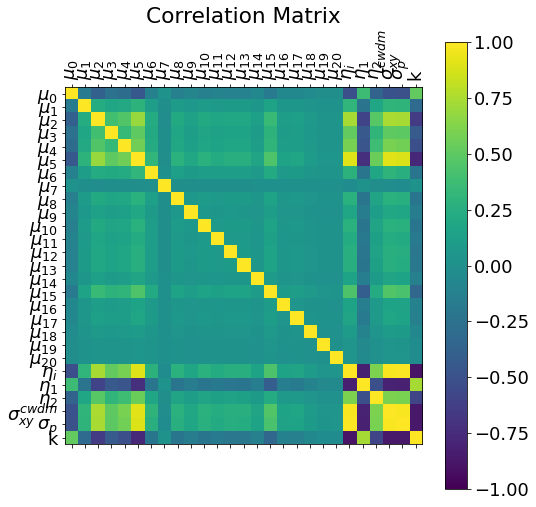

In [18]:
plt.figure(1, figsize=(8,8))
corr = correlation_from_covariance(np.array(minimizer.covariance))
ax = plt.matshow(corr, fignum=1)
plt.xticks(np.arange(len(parNamesB)), parNamesB, rotation=90)
plt.yticks(np.arange(len(parNamesB)), parNamesB)
plt.clim(-1, 1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.savefig('../fig/correlation_matrix.png', bbox_inches='tight')

## Post-fit plots

In [19]:
fr = FitResults(mu=p_hat[:-6], mu_err=p_hat_err[:-6], 
                eta= {'i': [p_hat[-6], p_hat_err[-6]], 
                      '1': [p_hat[-5], p_hat_err[-5]], 
                      '2': [p_hat[-4], p_hat_err[-4]]},
                sigma_xy=p_hat[-3], sigma_xy_err=p_hat_err[-3],
                sigma_p=p_hat[-2], sigma_p_err=p_hat_err[-2],
                k=p_hat[-1], k_err=p_hat_err[-1])

Sum pull^2: 30.84722109873511
Sum pull^2: 35.85131440095249


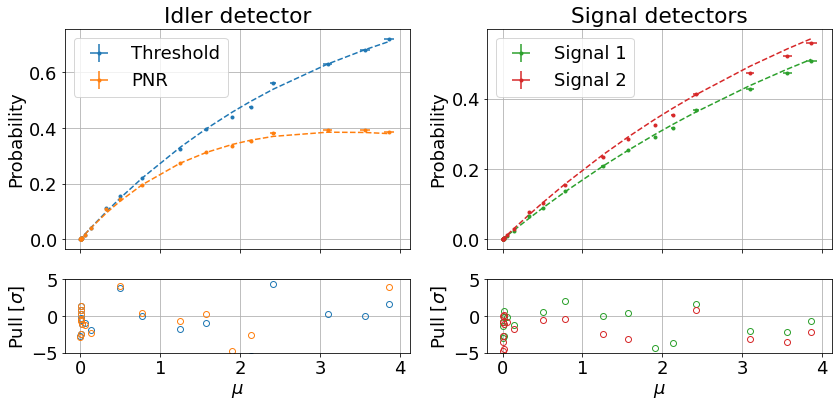

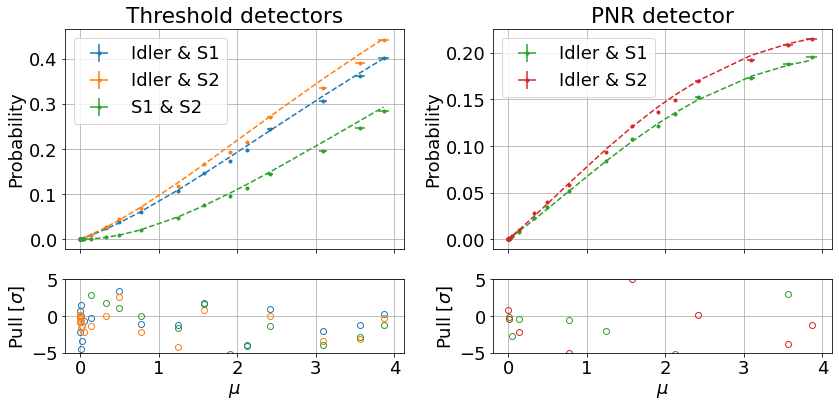

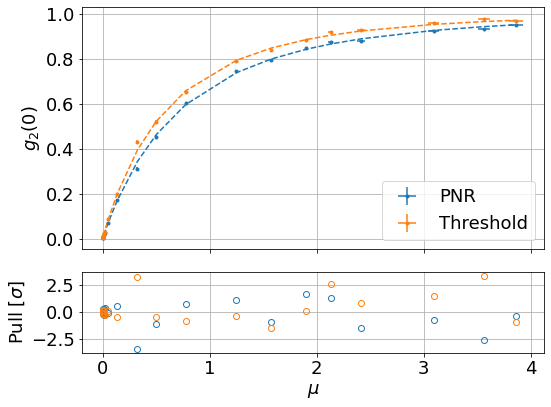

In [20]:
plotSingleDetectors(inputData, fr, saveas='../fig/detector_counts_postfit.pdf')

plotTwofold(inputData, fr, saveas='../fig/twofold_coincidences_postfit.pdf')

plot_g2_0(inputData, fr, saveas='../fig/g2_0_postfit.pdf');

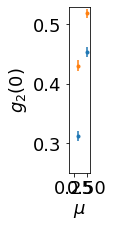

In [21]:
frZoom = deepcopy(fr)
frZoom.mu = frZoom.mu[9:13]
frZoom.mu_err = frZoom.mu_err[9:13]
plot_g2_0_zoommed(df.iloc[9:13], frZoom, figsize=(2,3.5), drawIdealModels=False, showLegend=False, force_xticks=False)
plt.ylim(0.25, 0.53)
plt.xlim(0.15, 0.55)
plt.savefig('../fig/g2_0_postfit_insert.png')
plt.savefig('../fig/g2_0_postfit_insert.pdf')

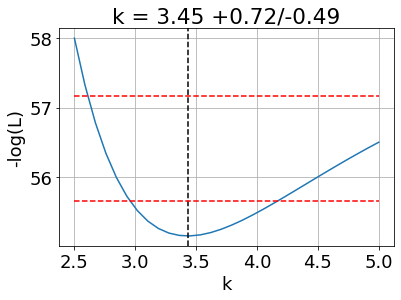

In [22]:
minimizer.print_level = 0
minimizer.strategy = 0
k_arr, NLL_arr = minimizer.draw_mnprofile('k', size=30, bound=(2.5, 5.), band=False, text=False)
plt.grid()
ymin = np.min(NLL_arr)
plt.plot(k_arr, k_arr.shape[0]*[ymin + 0.5], 'r--')
plt.plot(k_arr, k_arr.shape[0]*[ymin + 2], 'r--')
plt.ylabel('-log(L)')
k_min = k_arr[np.argmin(NLL_arr)]
fDw = interp1d((NLL_arr-ymin)[k_arr < k_min], k_arr[k_arr < k_min], kind='cubic')
k_Dw = fDw(0.5)
fUp = interp1d((NLL_arr-ymin)[k_arr > k_min], k_arr[k_arr > k_min], kind='cubic')
k_Up = fUp(0.5)
plt.title('k = {:.2f} +{:.2f}/-{:.2f}'.format(k_min, k_Up-k_min, k_min-k_Dw))
plt.savefig('../fig/NLLscan_k.png', bbox_inches='tight')

mu_star: 0.020467826086956523
mu_star (k=10): 0.02667304347826087


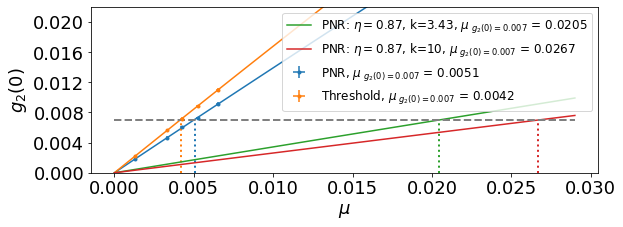

In [26]:
frZoom = deepcopy(fr)
frZoom.mu = frZoom.mu[:5]
frZoom.mu_err = frZoom.mu_err[:5]

plot_g2_0_zoommed(df.iloc[:5], frZoom, drawIdealModels=True, showLegend=True, saveas='../fig/g2_0_zoom_postfit.pdf')

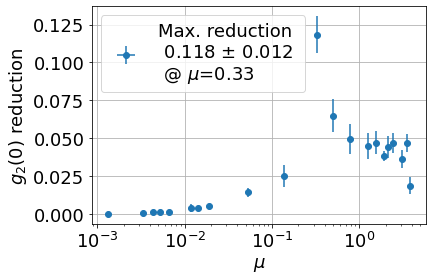

In [24]:
df['red_g2'] = df['g2_thr'] - df['g2_pnr']
df['red_g2_err'] = np.hypot(df['g2_thr_err'], df['g2_pnr_err'])
df['mu_hat'] = fr.mu
df['mu_hat_err'] = fr.mu_err
e = df[['mu_hat', 'red_g2', 'red_g2_err']].iloc[np.argmax(df['red_g2'])]

s = 'Max. reduction \n {:.3f} $\pm$ {:.3f} \n @ $\mu$={:.2f}'.format(e.red_g2, e.red_g2_err, e.mu_hat)
plt.errorbar(df['mu_hat'], df['red_g2'], yerr=df['red_g2_err'], xerr=df['mu_hat_err'], fmt='o', label=s)
plt.ylabel(r'$g_2(0)$ reduction')
plt.xlabel('$\mu$')
plt.xscale('log')
plt.legend(loc='upper left')
plt.grid()
plt.savefig('../fig/g2_reduction.pdf')